In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Loading and Exploring data

## Loading data

Here we define the dataframes from CSV files :
- **Training Data**
- **Testing Data** for making submission.
- **Sample Data** is a portion of Training data to run Grid Search faster.

The **Submission function** will be used to conveniently make submissions.

In [40]:
df_train = pd.read_csv("train-set.csv")
df_test = pd.read_csv("test-set.csv")
df_sample = df_train.sample(n=50000)

# Submission function
def submission(df_test, y_test, sub_nb='0'):
    dict_sub = OrderedDict([('Id', df_test.Id), ('Cover_Type', y_test)])
    df_sub = pd.DataFrame.from_dict(dict_sub)
    df_sub.to_csv('submission/forest_submission00'+sub_nb+'.csv', index=False)
    print("Submission file number "+sub_nb+" was created.")

# Exploring the Datasets
print(df_train.shape[1], " columns.", df_train.shape[0], " observations.")
print(df_test.shape[1], " columns.", df_test.shape[0], " observations.")
print(df_test.columns)

X_train = df_train.loc[:, df_train.columns != 'Cover_Type']
y_train = df_train.Cover_Type

56  columns. 528720  observations.
55  columns. 226595  observations.
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'So

- Elevation quantitative meters Elevation in meters
- Aspect quantitative azimuth Aspect in degrees azimuth
- Slope quantitative degrees Slope in degrees
- Horizontal_Distance_To_Hydrology quantitative meters Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology quantitative meters Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways quantitative meters Horz Dist to nearest roadway
- Hillshade_9am quantitative 0 to 255 index Hillshade index at 9am, summer solstice
- Hillshade_Noon quantitative 0 to 255 index Hillshade index at noon, summer soltice
- Hillshade_3pm quantitative 0 to 255 index Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points quantitative meters Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns) qualitative 0 (absence) or 1 (presence) Wilderness area designation
- Soil_Type (40 binary columns) qualitative 0 (absence) or 1 (presence) Soil Type designation
- Cover_Type (7 types) integer 1 to 7 Forest Cover Type designation

## Exploring data

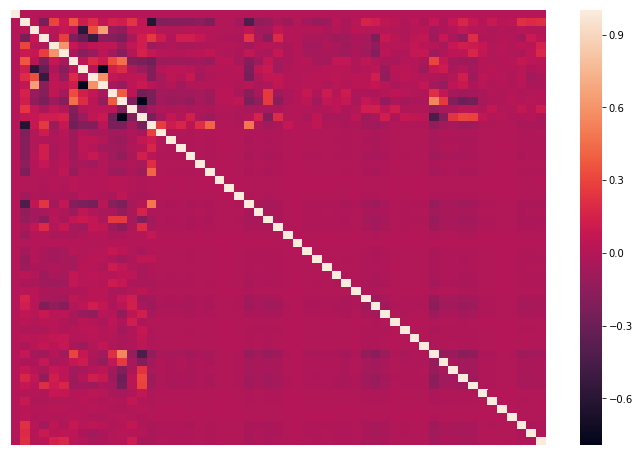

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(X_train.corr(), xticklabels=False, yticklabels=False)
plt.show()

We can clearly see on this correlation matrix heatmap that the first variables are the modt relevant and the soil-type variables are less important as they are a one-hot encoder and hold a lot of zero values. We may ignore them to lighten computations.

## Google Cloud Platform 

For this competition, the training set is voluminous and I realized training machine learning models on my laptop was in some cases very long. So I took this challenge as an opportunity to learn : 
- Taking first steps with Google Cloud environment.
- Launching a VM instance with appropriate setup and take advantage of the free tier offer.
- Connect to the VM, transfer working data, installing Jupyter Notebook
- Train models without having my laptop running all night.

I learned a lot about GCP and I find this is as important tool for the data scientist as cloud platforms are very common now in tech companies, it is a cheap and efficient way to get good computation ressources. I will for sure keep on learning on cloud environments.

Observations :
- Computation time is shorter for training models.
- Easy to find good learning materials for cloud platforms.
- GCP offers 300$ credits which is more than enough for several months.

# Dataviz

## Features exploration

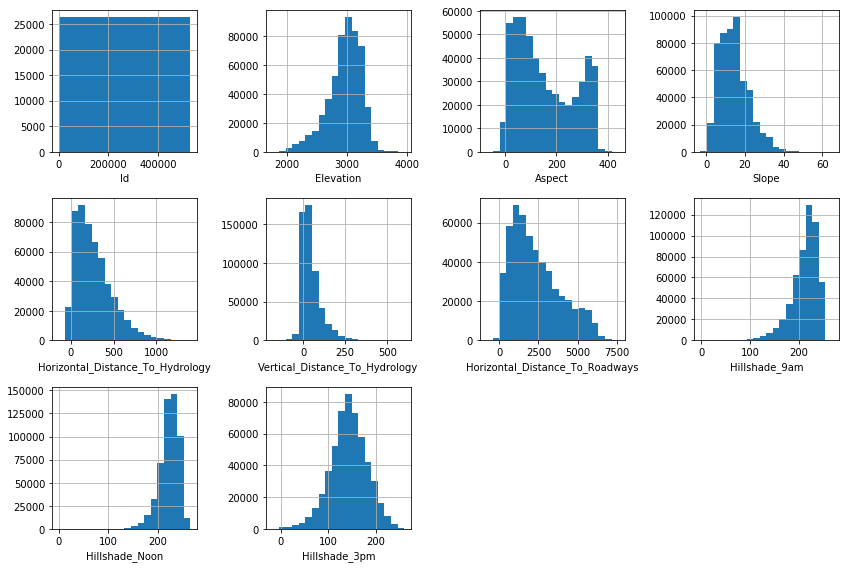

In [22]:
import matplotlib.gridspec as gridspec

def get_axes( gs, plt, rows, cols ):
    axes = list()
    for i in range(rows):
        for j in range(cols):
            axes.append( plt.subplot( gs[i,j] ) )
    return axes

rows, cols = 3, 4
fig  = plt.figure(figsize=(12, 8))
gs   = gridspec.GridSpec(rows, cols)
axes = get_axes( gs, plt, rows, cols )

plot_these = df_train.columns[:10]

for i, feature_name in enumerate(plot_these):
    df_train[feature_name].hist(ax=axes[i], bins=20)
    axes[i].set_xlabel(feature_name)
axes[10].axis('off')
axes[11].axis('off')
plt.tight_layout()

plt.show()

## Elevation Data

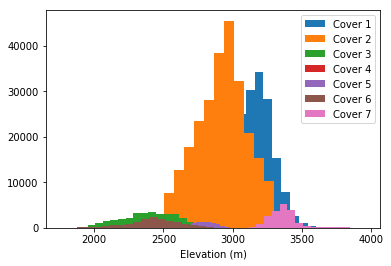

In [3]:
# Plotting Elevation data
plt.figure(figsize=(6,4))
label=['Cover ' + str(x) for x in range(1,8)]
for i in range(7):
    ax = plt.hist(df_train.Elevation[df_train.Cover_Type==i+1],label=label[i], bins=20,stacked=True)
plt.legend()
plt.xlabel('Elevation (m)')
plt.show()

We can see elevation is important in the classification. At first sight we can identity value intervals.

## Hill Shades

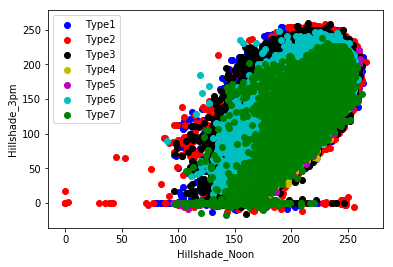

In [4]:
colors = ['b','r','k','y','m','c','g']
plt.figure(figsize=(6,4))
for i in range(7):
    plt.scatter(df_train.Hillshade_Noon[df_train.Cover_Type==i+1], df_train.Hillshade_3pm[df_train.Cover_Type==i+1], color=colors[i], label='Type' +str(i+1))
plt.xlabel('Hillshade_Noon')
plt.ylabel('Hillshade_3pm')
plt.legend()
plt.show()

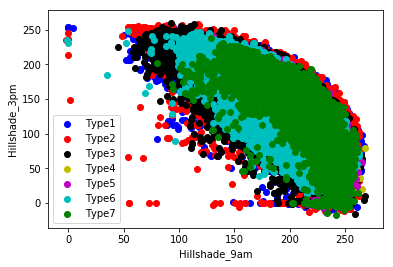

In [5]:
plt.figure(figsize=(6,4))
for i in range(7):
    plt.scatter(df_train.Hillshade_9am[df_train.Cover_Type==i+1], df_train.Hillshade_3pm[df_train.Cover_Type==i+1], color=colors[i], label='Type' +str(i+1))
plt.xlabel('Hillshade_9am')
plt.ylabel('Hillshade_3pm')
plt.legend()
plt.show()

# Feature engineering

I only added a value for water distance, but I am conscious there are more features to be created :
- Combine the Soil Types columns.
- Combine Hillshade data.
- Combine 

## Combining water distance

We can see distance to water is a pretty relevant feature to identify forest type.
Here we combine horizontal and vertical distance to add a new variable.

In [30]:
dist_to_water = df_train.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]\
    .apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
dist_to_water_test = df_test.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]\
    .apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
dist_to_water_sample = df_sample.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]\
    .apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)

dist_to_water = pd.DataFrame(dist_to_water, columns=['dist_to_water'])
dist_to_water_test = pd.DataFrame(dist_to_water_test, columns=['dist_to_water_test'])
dist_to_water_sample = pd.DataFrame(dist_to_water_sample, columns=['dist_to_water_test'])

df_train = pd.concat([df_train, dist_to_water], axis=1)
df_test = pd.concat([df_test, dist_to_water_test], axis=1)
df_sample = pd.concat([df_sample, dist_to_water_sample], axis=1)

# KNearestNeighbors

We will start with a KNN classifier, associated with a GridSearchCV to find optimal parameters. 
- **Large scale grid-search :** df_sample of 20,000 records is used to go through around 3500 parameters combinations. In order to identify a zone for refined gridSearch.
- **Reduced Grid-search :** Then we use the complete training set on a restrained set of values for the grid search.

In [ ]:
X_train_partial = df_train[["Elevation", "Aspect", "Slope", "dist_to_water", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]]
X_train_full = df_train[df_train.columns.difference(['Cover_Type'])]
Y_train = df_train.Cover_Type

X_test_partial = df_test[["Elevation", "Aspect", "Slope", "dist_to_water", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]]
X_test_full = df_test[df_test.columns.difference(['Cover_Type'])]


knn = KNeighborsClassifier()

# Custom Values for KNN Parameters
param_grid = {
    'n_neighbors': [5, 10, 20, 30, 40],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [int(x) for x in np.linspace(start = 10, stop = 200, num = 8)],
    'p': [1, 2, 3],
    'metric': ['minkowski'], 
    'n_jobs': [1]
}

'''
grid_search = GridSearchCV(
    estimator = knn, param_grid = param_grid, 
    cv = 3, n_jobs = 1, verbose = 1)
grid_search.fit(X_sample_partial, Y_train)
grid_search.best_params_
'''

# USING BEST PARAMS FROM GRID SEARCH
knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=5, weights='uniform')

print("Fit & Predict for a subset of features")
knn.fit(X_train_partial, Y_train)
#y_test = knn.predict(X_test_partial)
#submission(df_test, y_test, sub_nb='1')

#print('Fitting for complete train_set...')
#knn.fit(X_train_full, Y_train_full)
#print('Predicting for complete test_set...')
#y_test = knn.predict(X_test_full)
#submission(df_test, y_test, sub_nb='2')

Submission 1 : **0.92144**

Submission 2 : **0.41**

- We can see KNeighbors gives pretty good results on a selected subset of features.
- On the other hand, training on the full training set was very slow, and gave bad results. Maybe there was a mistake here.

# Voting Classifier : Mixing models


As I read some articles about ensemble learning, I wanted to experiment mixing various simple models weighted by voting mechanism. Here I combine various models from Scikitlearn in a Voting Classifier : It is based on a simple majority rule to determine the weight of each algorithm.
- Linear Regression
- Decision Tree
- Gaussian Naive Bayes
- Random Forest
- K Neighbors
- Extra Trees

Submission : **0.90877**

In [46]:
lr = LogisticRegression(random_state=1)
tree = DecisionTreeClassifier(random_state=1)
gnb = GaussianNB()
rfc = RandomForestClassifier(random_state=1)
adab = AdaBoostClassifier(random_state=1)
extratree = ExtraTreesClassifier(random_state=1)
knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=5, weights='uniform')

In [48]:
X_train_sample = df_sample[df_sample.columns.difference(['Cover_Type'])]
Y_train_sample = df_sample.Cover_Type

model_test2 = VotingClassifier(
        estimators=[
            ('lr', lr), ('dt', tree), ('gnb', gnb), ('knn', knn), ('xtt', extratree)], 
        voting='soft')

#model_test1.fit(X_train, Y_train)
print("Fitting models...")
model_test2.fit(X_train_sample, Y_train_sample)

print("Making predictions...")
X_test = df_test[df_test.columns.difference(['Cover_Type'])]
Y_test = model_test2.predict(X_test)

submission(df_test, Y_test, sub_nb='3')

Fitting models...
Making predictions...


/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Submission file number 3 was created.


- VotingClassifier - Soft voting, sample 20.000 records fitting : **0.77**
- VotingClassifier - Soft voting, sample 100.000 records fitting : **0.832**

Finally, VotingClassifier gives good results, but less than KNNeighbors. Results seems to be better with more tuning and more training data. 

# Extra Tree Classifier

I focused on extra tree classifier because it appeared to be the most efficient for this competition.

Extra Tree Classifier (standing for **ext**remely **ra**ndomized **trees**) is a variant of Random Forest. Unlike a random forest, at each step the entire sample is used and decision boundaries are picked at random, rather than the best one. Performance is comparable to an ordinary random forest, sometimes a bit better. 

## Hyperparameter search 

- First define work data and model.
- Grid Search and Randomized Search can be combined to go through a large set of hyperparameters.

In [28]:
X_train_sample = df_sample[['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
    'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]
Y_train_sample = df_sample.Cover_Type

extratree = ExtraTreesClassifier(
    bootstrap=False, 
    criterion='entropy', 
    #n_estimators=400,
    min_samples_leaf=1, 
    random_state=1, 
    #max_depth=252, 
    max_features=None)

###  Grid Search

GridSearchCV goes through the entire parameter grid.

In [29]:
param_grid_xtt = {
    'n_estimators': [400],
    'criterion':['entropy'], 
    'max_depth':[26],
    'min_samples_split':[2], 
    #'min_samples_leaf':range(1, 50, 5),
    #'min_weight_fraction_leaf':[0.0], 
    'max_features':[None], 
    #'max_leaf_nodes':None, 
    #'min_impurity_decrease':[0.0], 
    #'min_impurity_split':None, 
    'bootstrap':[False], 
    #'oob_score':False, 
    #'warm_start':False, 
    #'class_weight':None
}

grid_search_xtt = GridSearchCV(
    estimator = extratree, 
    cv = 4,
    param_grid = param_grid_xtt,
    verbose = 2,
    n_jobs = -1
)

grid_search_xtt.fit(X_train_sample, Y_train_sample)
grid_search_xtt.best_params_


Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV] bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV] bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV] bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400, total= 1.5min
[CV]  bootstrap=False, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400, total= 1.5min
[CV] bootstrap=True, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV] bootstrap=True, criterion=entropy, max_depth=26, max_features=None, min_samples_split=2, n_estimators=400 
[CV]  boo

[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.9min remaining:   58.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.9min finished


{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 26,
 'max_features': None,
 'min_samples_split': 2,
 'n_estimators': 400}

### Randomized Search

Here we use RandomizedSearchCV.

It uses random values from the param grid, it is a more efficient way to go over a large paramgrid.

In [ ]:
param_grid_xtt = {
    'n_estimators': range(200, 300, 1),
    #'criterion':['entropy'], 
    'max_depth':range(230, 300, 1),
    #'min_samples_split':2, 
    #'min_samples_leaf':range(1, 50, 5),
    #'min_weight_fraction_leaf':[0.0], 
    #'max_features':['auto', None, 'sqrt', 'log2'], 
    #'max_leaf_nodes':None, 
    #'min_impurity_decrease':[0.0], 
    #'min_impurity_split':None, 
    #'bootstrap':False, 
    #'oob_score':False, 
    #'n_jobs':None, 
    #'random_state':None,
    #'warm_start':False, 
    #'class_weight':None
}

random_search_xtt = RandomizedSearchCV(
    estimator = extratree, 
    param_distributions = param_grid_xtt, 
    n_iter = 10, 
    cv = 3, 
    verbose=1, 
    random_state=42, 
    n_jobs = 1)

random_search_xtt.fit(X_train_sample, Y_train_sample)
random_search_xtt.best_params_

## Applying Extra Tree Classifier

After finding good parameters with a sample dataset and our paramGrid, we apply it with the ExtraTreeClassifier.

In [33]:
X_train_full = df_train[['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
    'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]
Y_train_full = df_train.Cover_Type
X_test_full = df_test[['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
    'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]

extratree = ExtraTreesClassifier(
    bootstrap=False, 
    criterion='entropy', 
    n_estimators=400, 
    min_samples_leaf=1, 
    random_state=1, 
    max_depth=26, 
    max_features=None 
)

print("fitting..")
extratree.fit(X_train_full, Y_train_full)
print("predicting..")
y_test = extratree.predict(X_test_full)

print("making submission")
submission(df_test, y_test, sub_nb='4')

fitting..
preidicting..
making submission
Submission file number 4 was created.


Score with Extra tree classifier : **0.95705**

- bootstrap=False, 
- criterion='entropy', 
- n_estimators=400,
- min_samples_leaf=1, 
- random_state=1, 
- max_depth=26, 
- max_features=None

This model gives the best results, after searching with a randomized search.

Randomized Search takes a sample of the parameters, and does not try all the combinations like a classic grid search. This is a better mean to find optimal parameters, instead of fitting with a smaller training set.

# Voting Classifier : Extra Tree and KNN

In [12]:
X_train_partial = df_train[['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4']]
X_test_partial = df_test[['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4']]

knn = KNeighborsClassifier(
    algorithm='auto', 
    leaf_size=10, 
    n_neighbors=5, 
    weights='uniform')

extratree = ExtraTreesClassifier(
    bootstrap=False, 
    criterion='entropy', 
    n_estimators=400,
    min_samples_leaf=1, 
    random_state=1, 
    max_depth=252, 
    max_features=None)

voting2 = VotingClassifier(estimators=[('knn', knn), ('xtc', extratree)], voting='hard')

print("Fitting models...")
voting2.fit(X_train_partial, Y_train_full)

print("Making predictions...")
y_test = voting2.predict(X_test_partial)

print("Making submission..")
submission(df_test, y_test, sub_nb='5')

Fitting models...
Making predictions...


/Users/Alex/Programmes/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making submission..
Submission file number 5 was created.


I expected an improvement by combining those models but it didn't.

# Conclusion

This kaggle competition was a good introduction to data/ML challenges.
- It was a good way to experiment a wide range of algorithms and compare them. 
- Learning to use cloud platforms for machine learning was very interesting.